In [1]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
env = gym.make("FrozenLake-v0")

In [3]:
action_space_size =  env.action_space.n
state_space_size = env.observation_space.n

print(state_space_size,action_space_size)

16 4


In [4]:
class ReplayMemory:
    #rotating buffer of size N
    def __init__(self,N,batch_size=1000):
        self.memory = []
        self.size = N
        self.batch_size =batch_size
    
    def add(self,experience):
        self.memory.append(experience)
        if(len(self.memory) > self.size):
            del self.memory[0]
    
    def replay(self):    
        #if(len(self.memory) < self.batch_size):
        #    return []
        #relay everything stored in small minibatches 
        # (currently of lenght 1)
        # in a random order to reduce correlation
        output = np.array(self.memory)
        np.random.shuffle(output)
        return output#[:self.batch_size]

#Define what our experience looks like
#[state,action,reward,next_state]

In [5]:
def to_onehot(length,index):
    output = torch.zeros(length)
    output[index] = 1
    return output
    


class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        
        # assuming our input is 16
        # and our output is 4
        self.dense1 = nn.Linear(16,256)
        self.dense2 = nn.Linear(256,4)
        
    
    
    def forward(self,x):
        if(type(x) != torch.int32):
            x = int(x)
            x = to_onehot(16,x)
            
        out = F.sigmoid(self.dense1(x))
        out = self.dense2(out)
        return out
    
 

# Learning Function
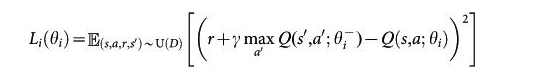

In [12]:
   

future_discount = .99

def learn_from_data(model,target,data,optimizer):
    for experience in data:
        #compute the loss from
        state,reward,action,next_state = experience
        state = int(state)
        next_state = int(next_state)
        action=int(action)
        
        
        #belman equation
        
        chosen_action_based_on_reward = model.forward(state)[action]
        expected_reward = reward + target.forward(next_state).max(0)[0].detach_()
        
        loss = F.l1_loss(chosen_action_based_on_reward.double(),expected_reward.double())
        #we want the chosen_action based on reward to match 
        #the reward of being in the next state and the reward given
        
        #print(reward)
        
        # must zero gradients before backprop
        # for pytorch 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [13]:
def get_best_action(model,state):
    #get our best action from our learner
    #print("state given:",state)
    action = model.forward(state).max(0)[1]
    action = int(action)
    #print("State:",state,"Action:",action)
    return action
    
def update_target(model,target):
    target.load_state_dict(model.state_dict())
    #print("model:",model.state_dict())
    #print("target:",target.state_dict())
    return target
    
    

def show_progress(episode,rewards,fidelity):
    clear_output()
    print("Episode:",episode)
    average =  [sum(rewards[fidelity*k:fidelity*(k+1)])/fidelity for k in range(int(len(rewards)/fidelity))]
    print("Best", max(average))
    plt.plot(average)
    plt.show()

# Training

In [14]:
num_episodes = 250000
max_steps_per_episode = 100

learning_rate = 0.05

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.0001

In [15]:
memory = ReplayMemory(1000)

In [16]:
model= DQN()
rewards = []
optimizer = optim.SGD(model.parameters(),lr=.01)
target = DQN()

        

Episode: 249500
Best 0.078


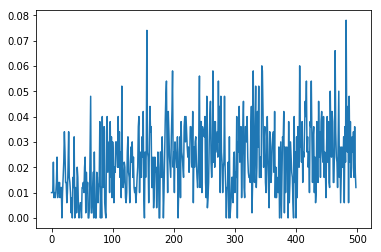

Exploration_rate: 0.010000000014453994


In [17]:
for episode in range(num_episodes):
    state = env.reset()
    #print("Episode: %d"%episode)
    
    done = False
    
    total_reward = 0
    
    game = []
    
    for step in range(max_steps_per_episode):
        #env.render()
        #clear_output()
        
        uniform_random_variable= random.uniform(0,1)
        
        if(uniform_random_variable > exploration_rate):
            #print("we took an action from the network")
            #exploit what we know
            action = get_best_action(model,state)
            
            #if(episode>1000):
            #    print("we chose:",action)
            
            
        else:
            #other wise explore randomly
            action = env.action_space.sample()
            
            
        #now that the action is chosen we take it
        new_state, reward, done, info = env.step(action)
        
        total_reward += reward
        
        #we save this experience to learn from later
        experience=[state,total_reward,action,new_state]
        
        #game.append(experience)
        memory.add(experience)
        state = new_state
        
        if(done):
            break
    
    #if(total_reward > 0):
        #[memory.add(experience) for experience in game]
        #print(len(memory.memory))
    
    #Decay the exploration rate after each loop
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    
    rewards.append(total_reward)
    
    if(episode % 100 == 0):
        learn_from_data(model,model,memory.replay(),optimizer)
        
        if(episode % 500==0 and episode!=0):
            #update the target model to match the model
            #target = update_target(model,target)
            show_progress(episode,rewards,500)
            print("Exploration_rate:",exploration_rate)
            
            #if(episode%1000==0):
        

[0.01, 0.016, 0.009, 0.009, 0.019, 0.011, 0.012, 0.01, 0.006, 0.013, 0.028, 0.02, 0.01, 0.015, 0.025, 0.012, 0.005, 0.008, 0.022, 0.006, 0.006, 0.018, 0.002, 0.005, 0.003, 0.012, 0.012, 0.022, 0.01, 0.012, 0.0, 0.016, 0.025, 0.006, 0.009, 0.016, 0.0, 0.017, 0.009, 0.026, 0.006, 0.02, 0.013, 0.021, 0.001, 0.037, 0.021, 0.02, 0.027, 0.02, 0.027, 0.013, 0.024, 0.028, 0.03, 0.027, 0.021, 0.03, 0.016, 0.018, 0.014, 0.008, 0.029, 0.017, 0.014, 0.025, 0.023, 0.018, 0.011, 0.008, 0.018, 0.038, 0.018, 0.018, 0.028, 0.025, 0.013, 0.021, 0.05, 0.015, 0.036, 0.035, 0.012, 0.014, 0.017, 0.019, 0.009, 0.023, 0.0, 0.026, 0.024, 0.01, 0.017, 0.043, 0.04, 0.026, 0.029, 0.018, 0.037, 0.039, 0.018, 0.027, 0.022, 0.016, 0.018, 0.02, 0.032, 0.022, 0.026, 0.035, 0.037, 0.026, 0.023, 0.029, 0.035, 0.031, 0.017, 0.025, 0.027, 0.014, 0.026, 0.034, 0.038, 0.023, 0.034, 0.036, 0.011, 0.026, 0.011, 0.035, 0.034, 0.019, 0.04, 0.029, 0.032, 0.032, 0.039, 0.037, 0.029, 0.024, 0.015, 0.035, 0.016, 0.006, 0.017, 0.016

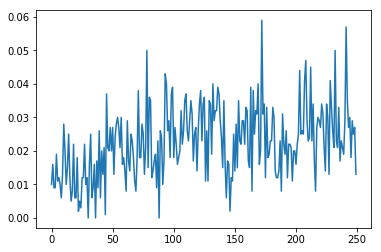

In [18]:
#average every 1000 episodes
average =  [sum(rewards[1000*k:1000*(k+1)])/1000 for k in range(int(len(rewards)/1000))]
print(average)

print("Best", average[-1])
plt.plot(average)
plt.show()

In [19]:
for episode in range(10):
    state = env.reset()
    #print("Episode: %d"%episode)
    
    done = False
    
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        clear_output()
        env.render()
        time.sleep(1)
        state = int(state)
        
        action = max(model.forward(state))
        action = int(action)

        state,reward,done,info = env.step(action)
        if(done):
            break
        


SFFF
FHFH
FFFH
HFFG


/home/andrew/.local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyError: 64257